In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy
import cv2
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
import pathlib
data_dir = "../Anime/"
data_dir = pathlib.Path(data_dir)

In [6]:
image_count=len(list(pathlib.Path(data_dir).glob('*/*.jpg')))
image_count

555056

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
img_shape = (256, 256, 3)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
STEPS_PER_EPOCH

17346.0

In [8]:
str(data_dir)+'/*/*'

'../Anime/*/*'

In [9]:
import os
print(os.getcwd())

/home/jasoni111/Desktop/cvpr/pythonScripts


In [10]:
list_ds = tf.data.Dataset.list_files('../Anime/0000/*')

In [11]:
train_gen = list_ds.take(int(image_count*0.95))
test_gen = list_ds.skip(int(image_count*0.95))

In [12]:
def process_path(file_path):
    #   label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [13]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [14]:
train_ds = train_gen.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_gen.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
train_ds = prepare_for_training(train_ds,cache=False)
test_ds  = prepare_for_training(test_ds,cache=False)

In [17]:
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')

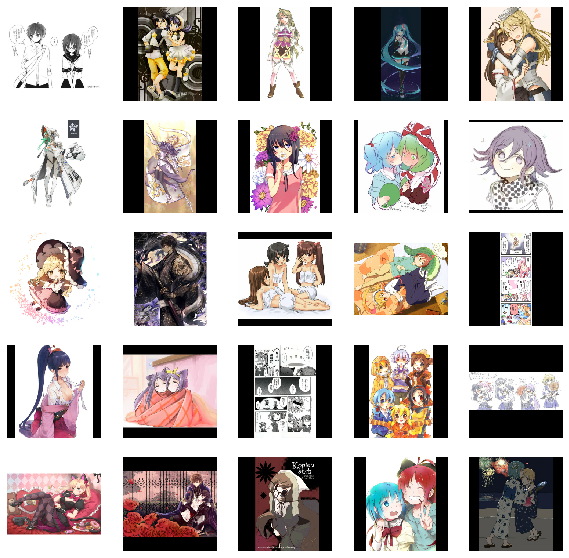

In [18]:
image_batch = next(iter(train_ds))
show_batch(image_batch)

In [19]:
image_batch.shape

TensorShape([32, 256, 256, 3])

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters):
        super(ConvBlock, self).__init__(name='conv_block')
        self.kernel_size = (5,5)
        self.strides = (2,2)
        self.filters = filters
        self.conv = tf.keras.layers.Conv2D(filters = self.filters,
                        kernel_size = self.kernel_size,
                        strides = self.strides,
                        padding='same',
                        data_format='channels_last',
                        use_bias=True,
                        )
#         self.conv = conv_layer(self.filters, self.kernel_size, self.strides)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.leaky_ReLU = tf.keras.layers.LeakyReLU(0.2)

    def call(self, inputs, training=False):
        inputs = self.conv(inputs)
        inputs = self.batch_norm(inputs, training=training)
        output = self.leaky_ReLU(inputs)
        return output

In [22]:
class TransposeConvBlock(tf.keras.Model):
    def __init__(self, filters):
        super(TransposeConvBlock, self).__init__(name='transpose_conv_block')
        self.kernel_size = (5,5)
        self.strides = (2,2)
        self.filters = filters
        self.transpose_conv = tf.keras.layers.Conv2DTranspose(filters= self.filters,
                                                                kernel_size =self.kernel_size,
                                                                strides = self.strides,
                                                                padding='same',
                                                                data_format='channels_last',
                                                                use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.ReLU = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):

        inputs = self.transpose_conv(inputs)
        inputs = self.batch_norm(inputs, training=training)
        output = self.ReLU(inputs)
        return output

In [23]:
class Discriminator(tf.keras.Model):
    # class for discriminator
    def __init__(self):
        super(Discriminator, self).__init__(name='Discriminator')
#         [32, 64, 128, 256, 512]
        self.disc_filters = [32, 64, 128]
        self.conv = tf.keras.layers.Conv2D(filters = self.disc_filters[0],
                                kernel_size = (5,5),
                                strides = (2,2),
                                padding='same',
                                data_format='channels_last',
                                use_bias=True,
                                )
        
        self.leaky_ReLU = tf.keras.layers.LeakyReLU(0.2)
        self.conv_blocks = [ConvBlock(self.disc_filters[i]) for i in range(1, len(self.disc_filters), 1)]
        self.flatten = tf.keras.layers.Flatten()
        self.Dense = tf.keras.layers.Dense(1, use_bias = True)

    def call(self, inputs, training=False):
        inputs = self.conv(inputs)
        inputs = self.leaky_ReLU(inputs)
        for conv_block in self.conv_blocks:
            inputs = conv_block(inputs, training=training)
        inputs = self.flatten(inputs)
        output = self.Dense(inputs)
        return output

In [24]:
class Generator(tf.keras.Model):
    # class for generator
    def __init__(self):
        super(Generator, self).__init__(name='Generator')
#         [1024, 512, 256, 128, 64]
        self.gen_filters = [256, 128, 64]
        self.img_shape = img_shape
        self.Dense = tf.keras.layers.Dense(units=4*4*self.gen_filters[0],use_bias = False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.ReLU = tf.keras.layers.ReLU()
        self.transpose_conv_blocks = [TransposeConvBlock(self.gen_filters[i]) for i in range(1, len(self.gen_filters), 1)]

        self.transpose_conv = tf.keras.layers.Conv2DTranspose(filters= self.img_shape[-1],
                                                                kernel_size =(5,5),
                                                                strides = (2,2),
                                                                padding='same',
                                                                data_format='channels_last',
                                                                use_bias=True)

    def call(self, inputs, training=False):
        print('A',inputs.shape)
        inputs = self.Dense(inputs)
        print('b',inputs.shape)
        inputs = tf.reshape(inputs, [-1, 4, 4, self.gen_filters[0]])
        print('c',inputs.shape)
#         inputs = self.batch_norm(inputs, training=training)
        print('d',inputs.shape)
        inputs = self.ReLU(inputs)
        print('e',inputs.shape)
        for transpose_conv_block in self.transpose_conv_blocks:
            inputs = transpose_conv_block(inputs, training=training)
        print('f',inputs.shape)
        inputs = self.transpose_conv(inputs)
        output = tf.nn.tanh(inputs)
        return output

In [25]:
G = Generator()
D = Discriminator()

In [26]:
disc_lr = 0.0002 
gen_lr = 0.0002  

beta1 = 0.5
beta2 = 0.999

In [27]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_lr, beta_1=beta1, beta_2=beta2)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=disc_lr, beta_1=beta1, beta_2=beta2)

In [28]:
train_writer = tf.summary.create_file_writer('..\TF_SUMMARY'+'\train')

In [29]:
ckpt = tf.train.Checkpoint(step=tf.Variable(0),\
                        generator_optimizer=gen_optimizer,
                        generator_model = G,
                        discriminator_optimizer=disc_optimizer,
                        discriminator_model=D)

In [30]:
# ckpt_manager = tf.train.CheckpointManager(ckpt,'..\TF_CHECK_POINT\DCGAN', max_to_keep=3)
# if restore:
#     latest_ckpt= tf.train.latest_checkpoint(Config.modelDir)
#         if not latest_ckpt:
#             raise Exception('No saved model found in: ' + Config.modelDir)
#         ckpt.restore(latest_ckpt)
#         global_step = int(latest_ckpt.split('-')[-1])   # .../ckpt-300 returns 300 previously trained totalbatches
#         print("Restored saved model from latest checkpoint")

In [31]:
step = 0

In [32]:
# latest_ckpt= tf.train.latest_checkpoint('..\TF_CHECK_POINT\DCGAN')
# if not latest_ckpt:
#     raise Exception('No saved model found in: ' + '..\TF_CHECK_POINT\DCGAN')

In [33]:
def compute_loss( labels, predictions):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,\
                    reduction=tf.keras.losses.Reduction.NONE)
    return cross_entropy(labels, predictions)

In [34]:
def disc_loss( real_output, fake_output):

    real_loss = compute_loss(tf.ones_like(real_output), real_output)
    fake_loss = compute_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    total_loss = total_loss/self.global_batchsize
    return total_loss

In [35]:
def gen_loss(fake_output):

    gen_loss = compute_loss(tf.ones_like(fake_output), fake_output)
    gen_loss = gen_loss / self.global_batchsize
    return gen_loss

In [36]:
# @tf.function
def train_step(real_imgs):
    
    print("wtf",real_imgs.shape)
    noise = tf.random.normal(shape=[tf.shape(real_imgs)[0],latent_dim])
    print("real_imgs,",real_imgs.shape)
    print("noise spae,",noise.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        print('G')
        generated_imgs = G(noise, training=True)
        print(generated_imgs.shape)
        print('D')
        real_output = D(real_imgs, training=True)
        print('D')
        fake_output = D(generated_imgs, training=True)
        print('G_1')
        d_loss = disc_loss(real_output, fake_output)
        print('G0')
        g_loss = gen_loss(fake_output)
    print('G1')
    G_grads = gen_tape.gradient(g_loss,G.trainable_variables)
    D_grads = disc_tape.gradient(d_loss, D.trainable_variables)
    print('G2')
    gen_optimizer.apply_gradients(zip(G_grads, G.trainable_variables))
    disc_optimizer.apply_gradients(zip(D_grads, D.trainable_variables))
    print('G3')
    #run g_optim twice to make sure d_loss doesn't go to zero
    with tf.GradientTape() as gen_tape:
        generated_imgs = G(noise, training=True)
        fake_output = D(generated_imgs, training=True)
        g_loss = gen_loss(fake_output)
    print('G4')
    G_grads = gen_tape.gradient(g_loss, G.trainable_variables)
    gen_optimizer.apply_gradients(zip(G_grads, G.trainable_variables))

    return g_loss, d_loss

In [37]:
# @tf.function
def gen_step(random_latents):
    gen_imgs = G(random_latents, training=False)
    return gen_imgs

In [38]:
# @tf.function
def train_loop(num_epochs, dist_dataset, dist_noise_dataset):

    num_batches = 0
    for i in range(num_epochs):
        print('At Epoch {}'.format(i+1))
        print('.........................................')
        one_batch = next(iter(dist_dataset))
        print(one_batch.shape)
#         for one_batch in dist_dataset:
        total_g_loss, total_d_loss = train_step(one_batch)

        with train_writer.as_default():
            tf.summary.scalar('generator_loss',total_g_loss, step=num_batches)
            tf.summary.scalar('discriminator_loss',total_d_loss, step=num_batches)

#             if(num_batches % Config.image_snapshot_freq == 0):
#                 for dist_gen_noise in dist_noise_dataset:
#                     gen_imgs = self.gen_step(dist_gen_noise)

#                 filename = Config.results_dir + 'fakes_epoch{:02d}_batch{:05d}.jpg'.format(i+1, num_batches)
            # save_image_grid(gen_imgs.numpy(), filename, drange=[-1,1], grid_size=Config.grid_size)

        num_batches+=1
        print('Gen_loss at batch {}: {:0.3f}'.format(num_batches, total_g_loss))
        print('Disc_loss at batch {}: {:0.3f}'.format(num_batches, total_d_loss))

#         ckpt.step.assign(i+1)
#         ckpt_manager.save()

In [39]:
random_seed = 42
num_gen_imgs = 32 
latent_dim = 100


gen_noise = tf.random.normal(shape=[num_gen_imgs, latent_dim], seed=random_seed)
gen_dataset = tf.data.Dataset.from_tensor_slices(gen_noise).repeat().batch(num_gen_imgs)
# dist_noise_dataset = strategy.experimental_distribute_dataset(gen_dataset)
print(next(iter(train_ds)).shape)
train_loop(3,train_ds,gen_dataset )

(32, 256, 256, 3)
At Epoch 1
.........................................
(32, 256, 256, 3)
wtf (32, 256, 256, 3)
real_imgs, (32, 256, 256, 3)
noise spae, (32, 100)
G
A (32, 100)
b (32, 4096)
c (32, 4, 4, 256)
d (32, 4, 4, 256)
e (32, 4, 4, 256)
f (32, 16, 16, 64)
(32, 32, 32, 3)
D
D


InvalidArgumentError: Matrix size-incompatible: In[0]: [32,2048], In[1]: [131072,1] [Op:MatMul]

### 

In [ ]:
next(iter(train_ds)).shape

In [ ]:
train_ds

In [ ]:
itr= iter(train_ds)

In [ ]:
next(itr)==next(itr)